In [30]:
import os
import random

import matplotlib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from einops import rearrange, reduce, repeat
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

In [13]:
# Set CMAP to gray
matplotlib.rcParams["image.cmap"] = "gray"

In [182]:
train_data = CIFAR10(
    root=os.path.join("..", "data", "tmp", "cifar"),
    download=True,
    train=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
)

X = train_data.data
X = torch.tensor(X) / 255

Files already downloaded and verified


In [183]:
# Load 16 images
samples = X[:6]
samples.shape

torch.Size([6, 32, 32, 3])

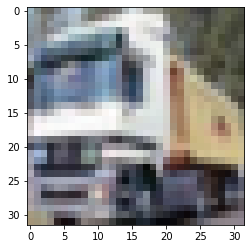

In [184]:
idx = random.randint(0, len(samples))
sample = X[idx]
plt.imshow(sample)

# Rearrange

## Play with axes

tensor(True)


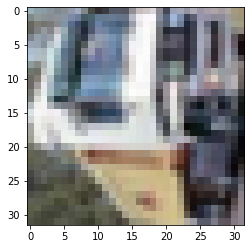

In [185]:
# Transpose width and height
res = rearrange(sample, "h w c -> w h c")
res2 = sample.permute(1, 0, 2)

print(torch.all(res == res2))

plt.imshow(res)

tensor(True)
torch.Size([192, 32, 3])


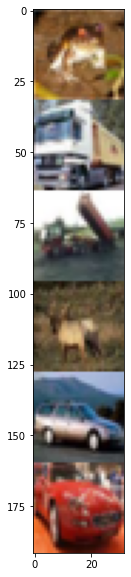

In [186]:
# Concatenate over height
res = rearrange(samples, "b h w c -> (b h) w c")
res2 = torch.vstack(tuple(samples))
# This works too
# res2 = torch.cat(tuple(samples))

print(torch.all(res == res2))
print(res.shape)

plt.figure(figsize=(5, 10))
plt.imshow(res)
plt.show()

tensor(True)
torch.Size([32, 192, 3])


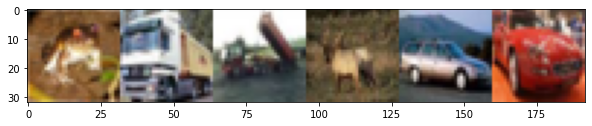

In [187]:
# Concatenate over width - new width = (b * w)
res = rearrange(samples, "b h w c ->  h (b w) c")
res2 = torch.hstack(tuple(samples))
# this works too
# res2 = torch.cat(tuple(samples), axis=1)

print(torch.all(res == res2))
print(res.shape)

plt.figure(figsize=(10, 5))
plt.imshow(res)
plt.show()

In [188]:
res = rearrange(samples, "b h w c -> (b h w c)")
res2 = torch.flatten(samples)

all(res == res2)

True

In [189]:
# Decompose b -> (b1, b2)
res = rearrange(samples, "(b1 b2) h w c -> b1 b2 h w c", b1=2, b2=3)
print(res.shape)

torch.Size([2, 3, 32, 32, 3])


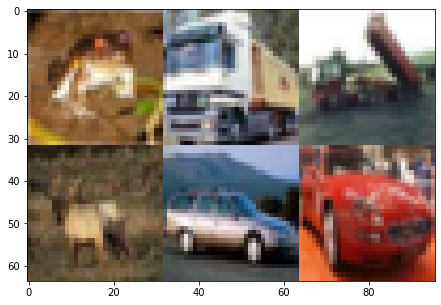

In [190]:
# Decompose b -> (b1, b2) and stack (b1 h) and (b2 w)
res = rearrange(samples, "(b1 b2) h w c -> (b1 h) (b2 w) c", b1=2, b2=3)

plt.figure(figsize=(10, 5))
plt.imshow(res)
plt.show()

In [191]:
# Decompose width into 2 x 16
res = rearrange(samples, "b h (w1 w2) c -> h w2 b w1 c", w1=16, w2=2)
print(samples.shape)
print(res.shape)

torch.Size([6, 32, 32, 3])
torch.Size([32, 2, 6, 16, 3])


torch.Size([64, 96, 3])


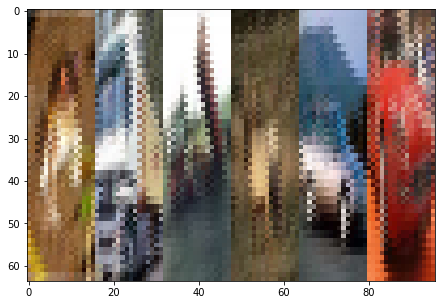

In [192]:
# decompose width w = w1 * w2 = 16 * 2.
# Then the new height becomes h * w2 = 32 * 2 = 64
# and the new width is b * w1 = 6 * 16 = 96
res = rearrange(samples, "b h (w1 w2) c -> (h w2) (b w1) c", w1=16, w2=2)

print(res.shape)

plt.figure(figsize=(10, 5))
plt.imshow(res)
plt.show()

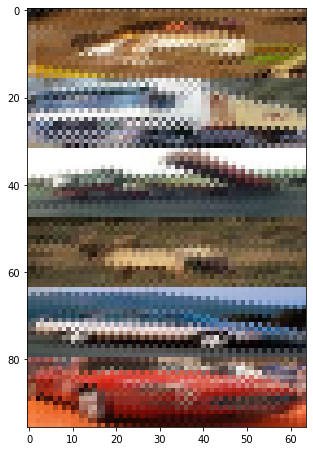

In [193]:
res = rearrange(samples, "b (h1 h2) w c -> (b h1) (w h2)  c", h1=16, h2=2)

plt.figure(figsize=(5, 10))
plt.imshow(res)
plt.show()

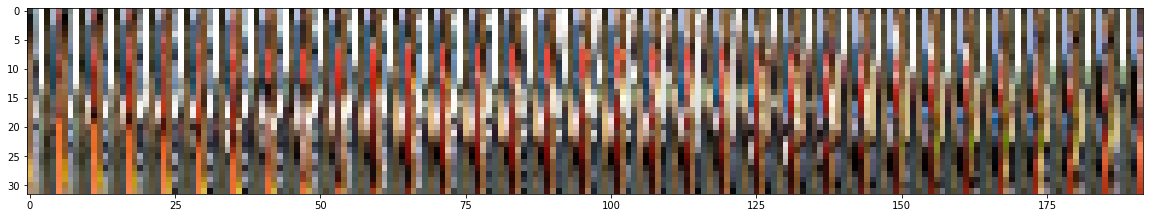

In [194]:
# Order matters
res = rearrange(samples, "b h w c -> h (w b) c")

plt.figure(figsize=(20, 5))
plt.imshow(res)
plt.show()

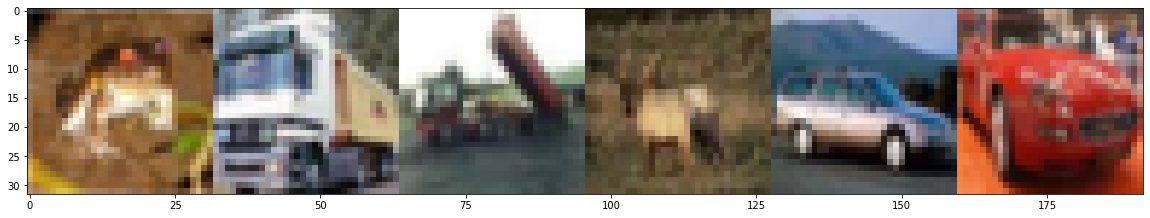

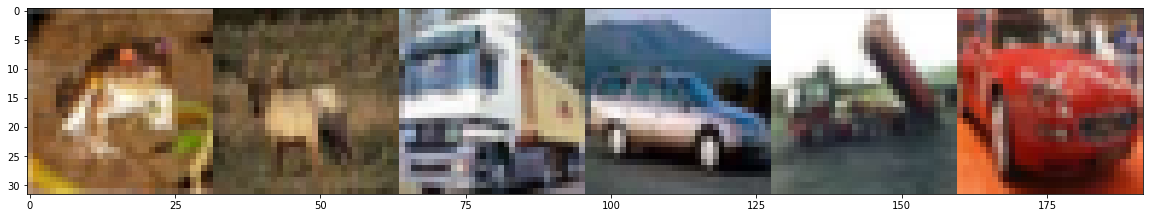

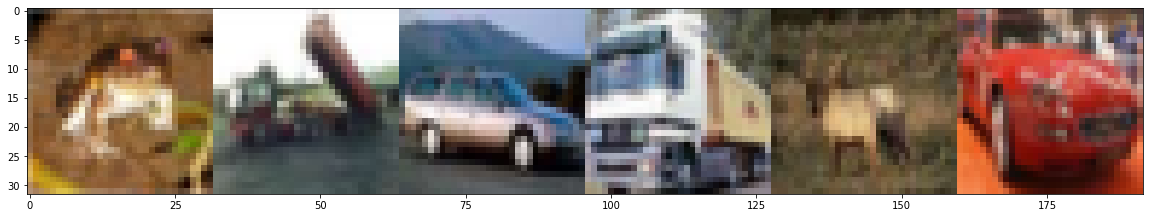

In [195]:
# Normal order
res = rearrange(samples, "b h w c -> h (b w) c")

plt.figure(figsize=(20, 5))
plt.imshow(res)
plt.show()

res = rearrange(samples, "(b1 b2) h w c -> h (b2 b1 w) c", b1=2, b2=3)

plt.figure(figsize=(20, 5))
plt.imshow(res)
plt.show()

res = rearrange(samples, "(b1 b2) h w c -> h (b2 b1 w) c", b1=3, b2=2)

plt.figure(figsize=(20, 5))
plt.imshow(res)
plt.show()

## Add and remove axes

In [226]:
res = rearrange(samples, "b h w c -> b 1 h w 1 c")
print(res.shape)

res = rearrange(res, "b 1 h w 1 c -> b h w c")
print(res.shape)

torch.Size([6, 1, 32, 32, 1, 3])
torch.Size([6, 32, 32, 3])


## Channelshuffle

In [334]:
t = torch.stack([torch.ones(32, 32) * v for v in torch.linspace(1, 256, 16) / 256])

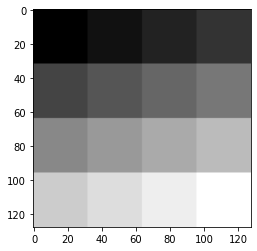

In [336]:
r = rearrange(t, "(c1 c2) h w -> (c1 h) (c2 w)", c1=4)
plt.imshow(r)

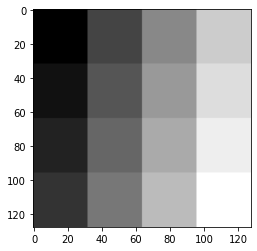

In [337]:
res = rearrange(t, "(g1 g2 c) h w -> (g2 g1 c) h w", g1=4, g2=4)

r = rearrange(res, "(c1 c2) h w -> (c1 h) (c2 w)", c1=4)
plt.imshow(r)

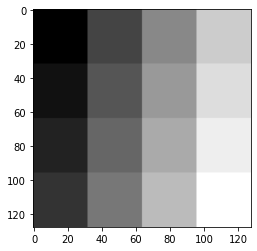

In [339]:
res = rearrange(t, "(g c) h w -> (c g) h w", g=4)

r = rearrange(res, "(c1 c2) h w -> (c1 h) (c2 w)", c1=4)
plt.imshow(r)

# Reduce

In [214]:
# Mean over channels
res = reduce(samples, "b h w c -> b h w", reduction="mean")

print(res.shape)

torch.Size([6, 32, 32])


torch.Size([32, 32, 3])


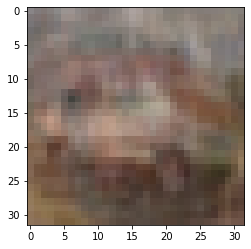

In [215]:
# Mean over batch
res = reduce(samples, "b h w c ->  h w c", "mean")

print(res.shape)

plt.imshow(res)
plt.show()

torch.Size([32, 32, 3])


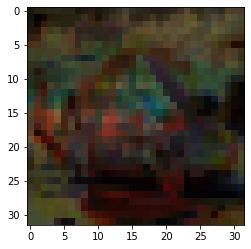

In [216]:
# Mean over batch
res = reduce(samples, "b h w c ->  h w c", "min")

print(res.shape)

plt.imshow(res)
plt.show()

torch.Size([6, 16, 16, 3])


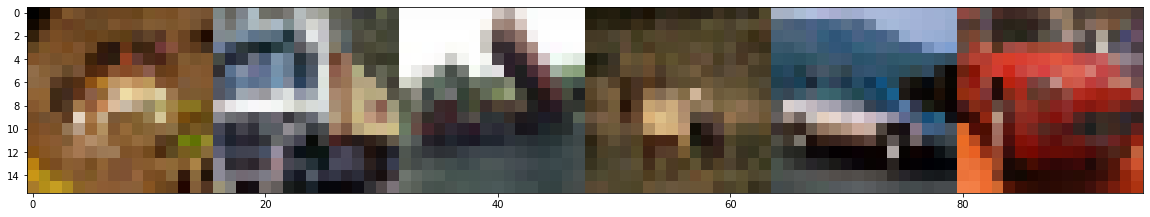

In [223]:
# min pooling with a 2x2 kernel
res = reduce(samples, "b (h h2) (w w2) c -> b h w c", "min", h2=2, w2=2)

print(res.shape)
res = rearrange(res, "b h w c -> h (b w) c")

plt.figure(figsize=(20, 5))
plt.imshow(res)
plt.show()

In [247]:
# Max over the dimension marked with ()
res = reduce(samples, "b h w c -> b () () c", "max")
print(res.shape)

torch.Size([6, 1, 1, 3])


In [249]:
# Similar
res = reduce(samples, "b h w c -> b 1 1 c", "max")
print(res.shape)

torch.Size([6, 1, 1, 3])


# Repeat

In [234]:
sample = samples[0]

torch.Size([32, 5, 32, 3])


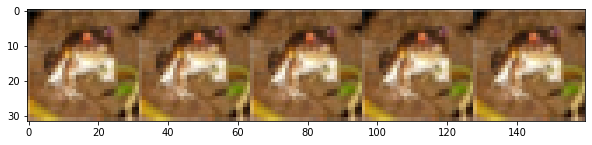

In [242]:
# Repeat element in a new axis

res = repeat(sample, "h w c -> h new_axis w c", new_axis=5)
print(res.shape)

res = rearrange(res, "h n w c -> h (n w) c")
plt.figure(figsize=(10, 5))
plt.imshow(res)
plt.show()

torch.Size([32, 160, 3])


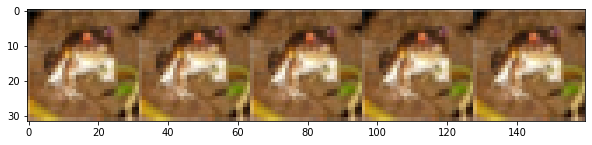

In [241]:
# Repeat over existing axis

res = repeat(sample, "h w c -> h (r w) c", r=5)
print(res.shape)

plt.figure(figsize=(10, 5))
plt.imshow(res)
plt.show()

torch.Size([32, 160, 3])


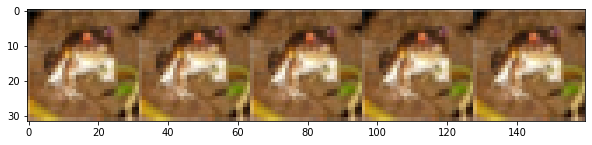

In [243]:
# Shortcut

res = repeat(sample, "h w c -> h (5 w) c")
print(res.shape)

plt.figure(figsize=(10, 5))
plt.imshow(res)
plt.show()

torch.Size([32, 160, 3])


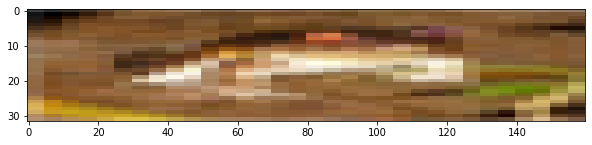

In [244]:
# Order matters.
res = repeat(sample, "h w c -> h (w 5) c")
print(res.shape)

plt.figure(figsize=(10, 5))
plt.imshow(res)
plt.show()

## Utils

In [340]:
from einops import asnumpy, parse_shape

In [349]:
parse_shape(samples, "batch h w c")

{'batch': 6, 'h': 32, 'w': 32, 'c': 3}

In [350]:
parse_shape(samples, "batch _ _ c")

{'batch': 6, 'c': 3}

In [363]:
# Converts tensor and also pulls from gpu if needed.

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
t = torch.randn(10, 1024, 3).to(device)
res = asnumpy(t)

type(res)

cuda


numpy.ndarray